# ANBW_v3
- To do
    - Improve model performance
    - Overfitting Troubleshooting
    - Reusable Pipeline Configuration
    - Apply appropriate garbage collecting

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [2]:
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
print("CUDA avilable:",
     True if tf.config.list_physical_devices("GPU") else False)

CUDA avilable: True


In [4]:
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load data

In [5]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

In [6]:
img_save_path = "./img/v3/"

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))
    print("Directory Created: %s" % img_save_path)
else:
    print("Directory already exists: %s" % img_save_path)

Directory already exists: ./img/v3/


## EDA

### Train data

In [7]:
train.set_index("id").head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [8]:
train_digit_cnt = train["digit"].value_counts(normalize=False, sort=False).values
train_digit_label = sorted(train["digit"].unique())

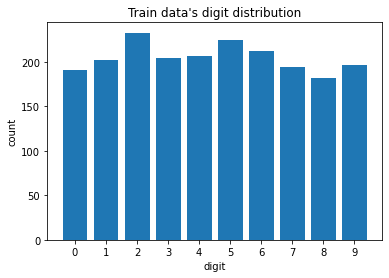

In [12]:
plt.bar(train_digit_label, train_digit_cnt)
plt.title("Train data's digit distribution")
plt.xticks(train_digit_label)
plt.xlabel("digit")
plt.ylabel("count")

img_path = img_save_path + "train_digit_distribution.png"
if not(os.path.isfile(img_path)):
    plt.savefig(img_path, facecolor="#eeeeee", bbox_inches="tight")

In [13]:
train.shape

(2048, 787)

### Test data

In [14]:
test.set_index("id").head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [15]:
test.shape

(20480, 786)

### Data visualization

In [ ]:
visualization_data = train.loc[:8]
